In [360]:
import nibabel as nb
import os
import matplotlib.pyplot as plt
import numpy as np

In [361]:
def normalize(v, new_max=1.0, new_min=0.0):
    min_v = np.min(v)
    max_v = np.max(v)

    v_new = (v-min_v)*(new_max-new_min)/(max_v-min_v) + new_min
    return v_new

In [381]:
path_data = "/home/snarduzz/Data/TEST/97645570/Neuro_Cerebrale_64Ch"
prefix = "coreg_"
basefile = os.path.join(path_data,prefix+"t2_tse_tra_97645570.nii")
baselesion = os.path.join(path_data,prefix+"VOI_lesion_97645570.nii")
base_img = nb.load(basefile).get_data()
base_lesion = nb.load(baselesion).get_data()
x = np.array([base_img])
y = np.array([base_lesion])

In [363]:
def plot(x,y=None, layer=90):
    if y is None:
        y=x
    x = x[0]
    y = y[0]
    x = normalize(x)
    y = normalize(y)
    img = np.zeros([x.shape[0],x.shape[1],3])
    img[:,:,1] = x[:,:,layer]
    img[:,:,0] = y[:,:,layer]
    plt.imshow(img)
    plt.show()

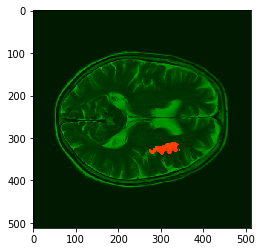

In [364]:
plot(x,y)

In [365]:
import scipy.ndimage as sn
def rotate3D(imgsx,imgsy,pitch,yaw,roll,reshape=False):
    def _rotateArray(x, pitch,yaw,roll, reshape=False):
        #pitch
        pitched = sn.rotate(x, angle=pitch, axes=(0,2), reshape=False)
        #yaw
        yawn = sn.rotate(pitched, angle=yaw, axes=(0,1), reshape=False)
        #roll
        rolled = sn.rotate(yawn, angle=roll, axes=(1,2), reshape=False)
        return rolled
    
    rotatedXs = []
    rotatedYs = []
    for x in imgsx:
        rotatedXs.append(_rotateArray(x,pitch,yaw,roll,reshape))
    for y in imgsy:
        rotatedYs.append(_rotateArray(y,pitch,yaw,roll,reshape))
    return rotatedXs,rotatedYs

In [366]:
def rotate3D_wiki(imgsx,imgsy,pitch,yaw,roll,reshape=False):
    def _rotateArray(x, pitch, yaw, roll, reshape=False):
        rx = np.array([[1,0,0],
                       [0, np.cos(roll), -np.sin(roll)],
                       [0, np.sin(roll), np.cos(roll)]])
        
        ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                       [0,1,0],
                       [-np.sin(pitch), 0, np.cos(pitch)]])
        
        rz = np.array([[np.cos(yaw),-np.sin(yaw),0],
                      [np.sin(yaw), np.cos(yaw),0],
                      [0,0,1]])
        
        return x.dot(rx).dot(ry).dot(rz)
    
    rotatedXs = []
    rotatedYs = []
    for x in imgsx:
        rotatedXs.append(_rotateArray(x,pitch,yaw,roll,reshape))
    for y in imgsy:
        rotatedYs.append(_rotateArray(y,pitch,yaw,roll,reshape))
    return rotatedXs,rotatedYs

In [367]:
def flip(imgsx,imgsy,axis=0):
    def _flip(img,axis):
        img = np.flip(img,axis)
        return img
    
    flippedXs = []
    flippedYs = []
    for x in imgsx:
        flippedXs.append(_flip(x,axis))
    for y in imgsy:
        flippedYs.append(_flip(y,axis))
    return flippedXs,flippedYs

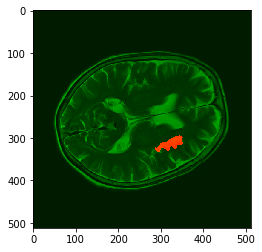

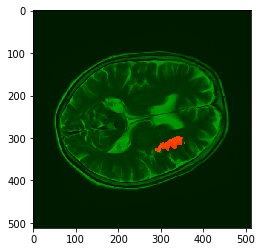

In [368]:
a,b = rotate3D(x,y,0,10.5,0)
plot(a,b)
a,b = rotate3D(x,y,0,10,0)
plot(a,b)

In [369]:
a,b = rotate3D(x,y,0,10,0)

In [371]:
def salt_and_pepper(imgsx,imgsy, salt_vs_pepper=0.2, amount=0.04):
    
    def _salt_and_pepper(x,salt_vs_pepper=0.2, amount=0.04):
        num_salt = np.ceil(amount * x.shape[0]*x.shape[1]*x.shape[2] * salt_vs_pepper)
        num_pepper = np.ceil(amount * x.shape[0]*x.shape[1]*x.shape[2] * (1.0 - salt_vs_pepper))
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in x.shape]
        x[coords[0], coords[1], coords[2]] = np.max(x)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in x.shape]
        x[coords[0], coords[1], coords[2]] = np.min(x)
        return x
    
    imgs_c = imgsx.copy()
    salted = []
    for x in imgs_c:
        salted.append(_salt_and_pepper(x,salt_vs_pepper,amount))
        
    return salted, imgsy

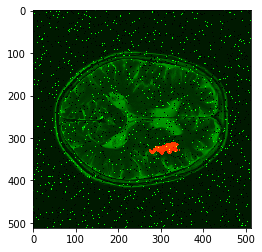

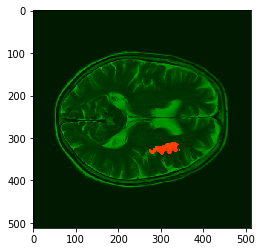

In [372]:
a,b = salt_and_pepper(x,y,salt_vs_pepper=0.4,amount=0.05)
plot(a,b)
plot(x,y)

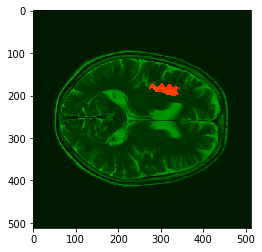

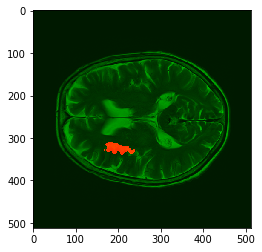

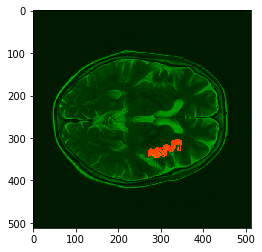

In [373]:
a,b = flip(x,y,axis=0)
plot(a,b)
a,b = flip(x,y,axis=1)
plot(a,b)
a,b = flip(x,y,axis=2)
plot(a,b)

In [374]:
def adjust_contrast(imgsx,imgsy,contrast=128,brightness=128):
    
    def normalize(v, new_max=1.0, new_min=0.0):
        new_max=float(new_max)
        new_min=float(new_min)
        min_v = np.min(v)
        max_v = np.max(v)

        v_new = ((v-min_v)*(new_max-new_min)/(max_v-min_v)) + new_min
        return v_new

    def _adjust_contrast(img,contrast=128.0,brightness=128.0):
        contrast=float(contrast)/128.0
        brightness=float(brightness)-128
        img_base = img.copy()
        img = normalize(img_base,new_max=255.0,new_min=0.0)
        #factor = (259.0 * (contrast + 255.0)) / (255.0 * (259.0 - contrast))
        #img = (factor*(img-128.0))+128.0
        img = contrast*(img-128.0)+128.0+brightness
        img[img<0]=0
        img[img>255]=255
        return normalize(img,new_max=np.max(img_base),new_min=np.min(img_base))
        
    imgs_c = imgsx.copy()
    contrasted = []
    for x in imgs_c:
        contrasted.append(_adjust_contrast(x,contrast,brightness))
        
    return contrasted, imgsy

In [375]:
from ipywidgets import interact, widget, IntSlider
def plot_contrast(contrast):
    a,b = adjust_contrast(x,y,contrast)
    plot(a,b)
interactive_plot = interact(plot_contrast, contrast=IntSlider(min=-255,max=255,step=1,value=1))

interactive(children=(IntSlider(value=1, description='contrast', max=255, min=-255), Output()), _dom_classes=(…

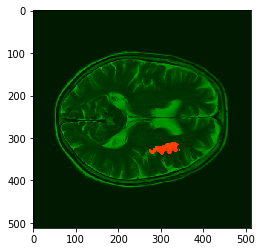

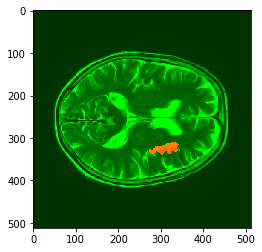

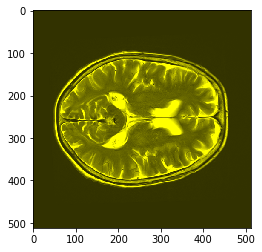

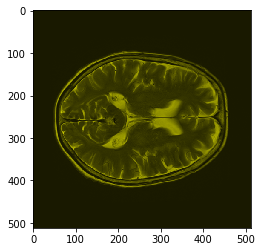

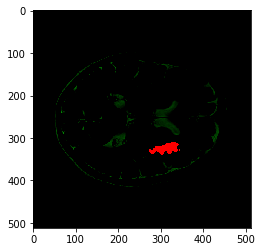

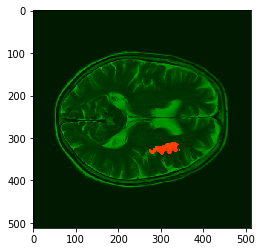

In [376]:
a,b = adjust_contrast(x,y,128,128)
plot(a,b)
a,b = adjust_contrast(x,y,128,255)
plot(a,b)
plot(a)
plot(x)
a,b = adjust_contrast(x,y,128,0)
plot(a,b)
plot(x,y)

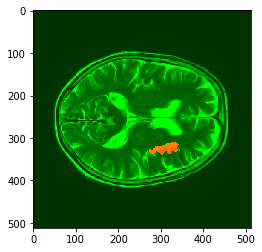

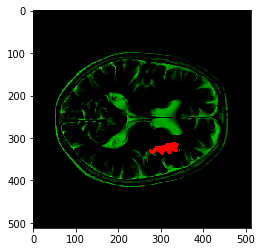

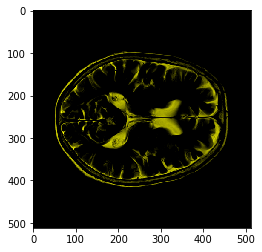

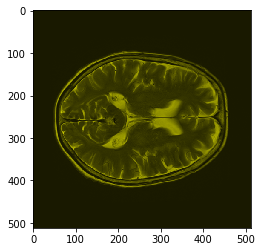

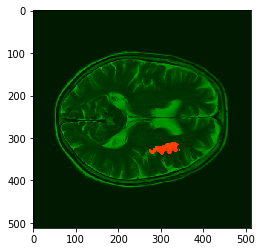

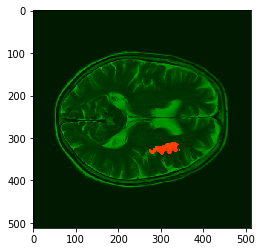

In [377]:
a,b = adjust_contrast(x,y,1,255)
plot(a,b)
a,b = adjust_contrast(x,y,255,128)
plot(a,b)
plot(a)
plot(x)
a,b = adjust_contrast(x,y,128,128)
plot(a,b)
plot(x,y)

In [387]:
import random
def randomlyAugment(imgsx,imgsy,prob=0.15):
    # randomly rotate
    r = random.random()
    if r < prob:
        degx = int(random.random()*359.0) # in degree
        degy = int(random.random()*359.0) # in degree
        degz = int(random.random()*359.0) # in degree
        imgsx, imgsy = rotate3D(imgsx,imgsy,degx,degy,degz)

    # randomly add salt and pepper
    r = random.random()
    if r < prob:
        imgsx, imgsy = salt_and_pepper(imgsx, imgsy,salt_vs_pepper=0.4,amount=0.05)
    
    # randomly flip
    r = random.random()
    if r < prob:
        ax = random.randint(0,2)
        imgsx, imgsy = flip(x,y,axis=ax)
        ax = random.randint(0,2)
        imgsx, imgsy = flip(x,y,axis=ax)
        ax = random.randint(0,2)
        imgsx, imgsy = flip(x,y,axis=ax)
    
    # randomly flip
    r = random.random()
    if r < prob:
        contrast = int(np.random.normal(loc=1.0,scale=0.3)*128)
        brightness = int(np.random.normal(loc=1.0,scale=0.3)*128)
        imgsx, imgsy = adjust_contrast(imgsx, imgsy, contrast, brightness)
    
    return imgsx, imgsy
        

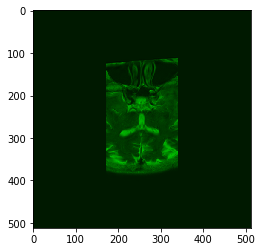

In [388]:
a,b =randomlyAugment(x,y)
plot(a,b)